<a href="https://colab.research.google.com/github/amitav710/SAiDl/blob/main/supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning

Importing the Libraries

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import argparse

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers

import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
import math
from tensorflow.keras import layers
from tensorflow.keras.layers import (
 Conv2D,
 BatchNormalization,
 Dense,
 MaxPool2D,
 Flatten,
 Dropout,
 Add,
 ReLU
)

Loading and formatting datasets

In [39]:
ds_train, info_train = tfds.load('stl10', split='train', with_info=True, shuffle_files=True, as_supervised=True)
df_train = tfds.as_dataframe(ds_train.take(5), info_train)
df_train.head()

,image,label
0,"[[[136, 144, 153], [125, 127, 136], [125, 126,...",1
1,"[[[70, 132, 186], [81, 139, 189], [143, 176, 2...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8
3,"[[[104, 90, 69], [101, 87, 66], [103, 88, 67],...",3
4,"[[[189, 204, 235], [189, 204, 235], [189, 204,...",9


In [40]:
ds_test, info_test = tfds.load('stl10', split='test', with_info=True, shuffle_files=True, as_supervised=True)
df_test = tfds.as_dataframe(ds_test.take(5), info_test)
df_test.head()

,image,label
0,"[[[213, 214, 220], [219, 219, 225], [220, 221,...",9
1,"[[[31, 36, 32], [37, 42, 42], [60, 63, 60], [5...",3
2,"[[[87, 87, 74], [84, 86, 76], [80, 82, 75], [8...",3
3,"[[[37, 76, 22], [40, 79, 22], [43, 76, 25], [4...",1
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",9


In [41]:
x_train=[]
y_train=[]
for data in ds_train:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_train.append(x)
  y_train.append(y)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train.shape

(5000, 96, 96, 3)

In [42]:
y_train = pd.get_dummies(y_train)
y_train.shape

(5000, 10)

In [43]:
x_test=[]
y_test=[]

for data in ds_test:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_test.append(x)
  y_test.append(y)

x_test = np.array(x_test)
y_test = np.array(y_test)

y_test = pd.get_dummies(y_test)

In [44]:
x_test.shape

(8000, 96, 96, 3)

In [45]:
y_test.shape

(8000, 10)

Image augmentation

In [46]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [47]:
training_set = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32
)

In [48]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_set=test_datagen.flow(
    x_test,
    y_test,
    batch_size=32
)

Making the CNN

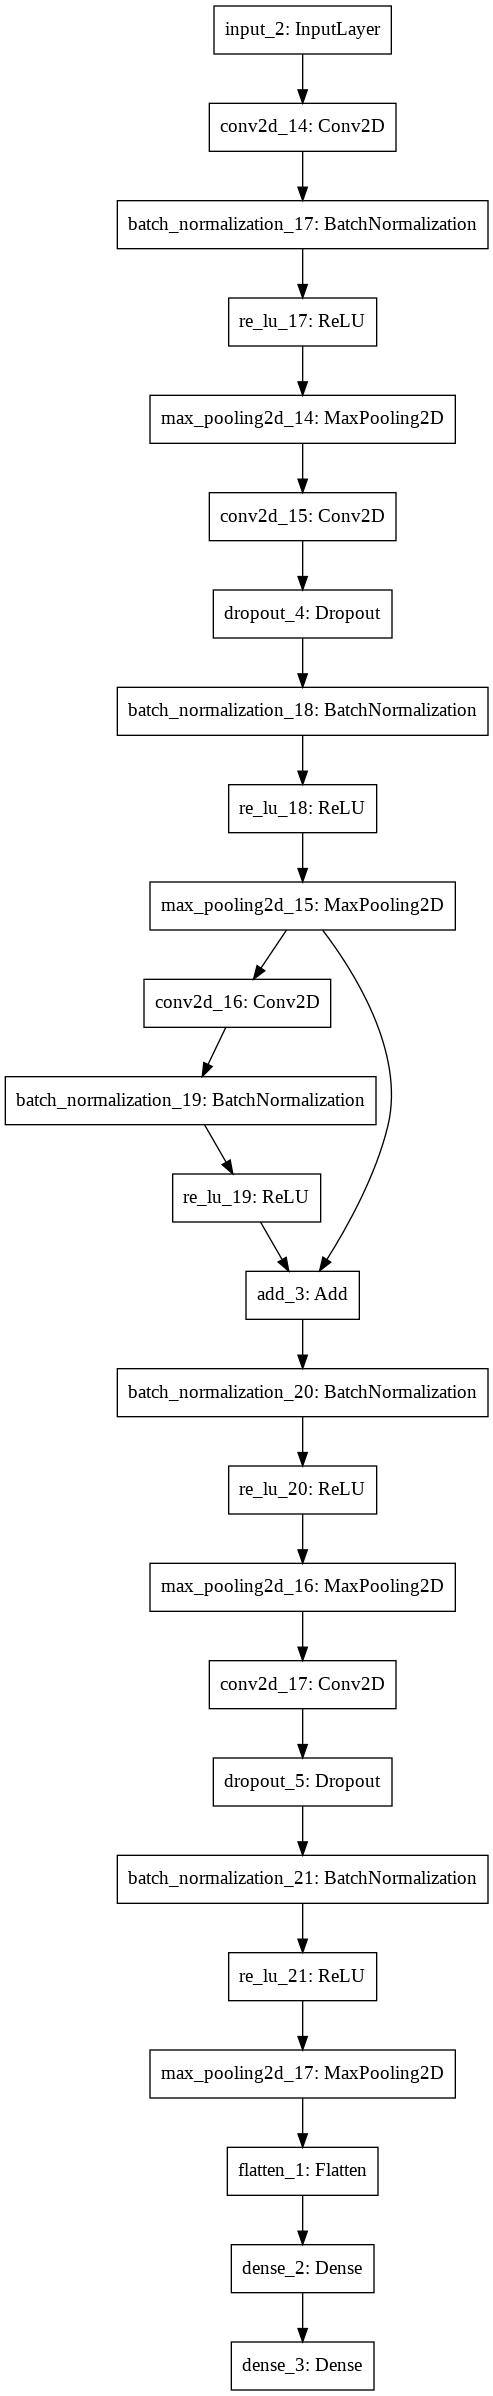

In [49]:
shape=(96,96,3)
input=layers.Input(shape)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x=(Dropout(0.2))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

#residual layer
x_copy1=x
x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x_copy2=x
x = Add()([x_copy1,x_copy2])
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (Dropout(0.2))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

#residual layer
x_copy3=x
x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x_copy4=x
x = Add()([x_copy3,x_copy4])
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (Dropout(0.2))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)
x = (Flatten())(x)
x = (Dense(128, activation = 'relu'))(x)
output = (Dense(units=10,activation = 'softmax'))(x)

cnn = tf.keras.Model(inputs=input, outputs=output)
plot_model(cnn)

In [50]:
stop = EarlyStopping(patience=25)

In [51]:
"""initial_learning_rate = 0.01
decay_steps = 10.0
decay_rate = 0.75
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate, 
  decay_steps, 
  decay_rate,
  staircase=True
)"""

'initial_learning_rate = 0.01\ndecay_steps = 10.0\ndecay_rate = 0.75\nlearning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(\n  initial_learning_rate, \n  decay_steps, \n  decay_rate,\n  staircase=True\n)'

Training the CNN

In [52]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0003)

In [53]:
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
model_checkpoint_callback = ModelCheckpoint('wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

In [55]:
cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 96, 96, 96)   2688        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 96, 96, 96)   384         conv2d_14[0][0]                  
__________________________________________________________________________________________________
re_lu_17 (ReLU)                 (None, 96, 96, 96)   0           batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [56]:
history=cnn.fit(x=training_set, validation_data=test_set, epochs= 120, batch_size=32, callbacks=[stop, model_checkpoint_callback])

Epoch 1/120
157/157 [==============================] - 17s 100ms/step - loss: 2.0131 - accuracy: 0.2840 - val_loss: 1.6926 - val_accuracy: 0.3714
Epoch 2/120
  1/157 [..............................] - ETA: 15s - loss: 1.5937 - accuracy: 0.4688

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 16s 99ms/step - loss: 1.6558 - accuracy: 0.3728 - val_loss: 1.4996 - val_accuracy: 0.4609
Epoch 3/120
157/157 [==============================] - 16s 99ms/step - loss: 1.5253 - accuracy: 0.4310 - val_loss: 1.4007 - val_accuracy: 0.4840
Epoch 4/120
157/157 [==============================] - 15s 98ms/step - loss: 1.4515 - accuracy: 0.4544 - val_loss: 1.3876 - val_accuracy: 0.4947
Epoch 5/120
157/157 [==============================] - 16s 99ms/step - loss: 1.3870 - accuracy: 0.4872 - val_loss: 1.2981 - val_accuracy: 0.5354
Epoch 6/120
157/157 [==============================] - 16s 99ms/step - loss: 1.3380 - accuracy: 0.5064 - val_loss: 1.2940 - val_accuracy: 0.5372
Epoch 7/120
157/157 [==============================] - 15s 99ms/step - loss: 1.2732 - accuracy: 0.5254 - val_loss: 1.2752 - val_accuracy: 0.5439
Epoch 8/120
157/157 [==============================] - 15s 98ms/step - loss: 1.2453 - accuracy: 0.5458 - val_loss: 1.2522 - val_accuracy: 0.53

In [60]:
history=cnn.fit(x=training_set, validation_data=test_set, epochs= 120, batch_size=32, callbacks=[stop, model_checkpoint_callback])

Epoch 1/120
157/157 [==============================] - 16s 99ms/step - loss: 0.4389 - accuracy: 0.8342 - val_loss: 0.9806 - val_accuracy: 0.6862
Epoch 2/120
157/157 [==============================] - 16s 99ms/step - loss: 0.4537 - accuracy: 0.8350 - val_loss: 0.9722 - val_accuracy: 0.6824
Epoch 3/120
157/157 [==============================] - 15s 98ms/step - loss: 0.4457 - accuracy: 0.8416 - val_loss: 1.0545 - val_accuracy: 0.6685
Epoch 4/120
157/157 [==============================] - 16s 99ms/step - loss: 0.4463 - accuracy: 0.8446 - val_loss: 1.0329 - val_accuracy: 0.6766
Epoch 5/120
157/157 [==============================] - 15s 99ms/step - loss: 0.4273 - accuracy: 0.8450 - val_loss: 0.9334 - val_accuracy: 0.6979
Epoch 6/120
157/157 [==============================] - 15s 98ms/step - loss: 0.4263 - accuracy: 0.8500 - val_loss: 1.1003 - val_accuracy: 0.6614
Epoch 7/120
157/157 [==============================] - 15s 99ms/step - loss: 0.4322 - accuracy: 0.8440 - val_loss: 1.0129 - val_ac

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 16s 99ms/step - loss: 0.3892 - accuracy: 0.8568 - val_loss: 1.1001 - val_accuracy: 0.6766
Epoch 18/120
157/157 [==============================] - 16s 99ms/step - loss: 0.3829 - accuracy: 0.8626 - val_loss: 1.1058 - val_accuracy: 0.6726
Epoch 19/120
157/157 [==============================] - 16s 100ms/step - loss: 0.3703 - accuracy: 0.8672 - val_loss: 1.0919 - val_accuracy: 0.6794
Epoch 20/120
157/157 [==============================] - 15s 98ms/step - loss: 0.3760 - accuracy: 0.8612 - val_loss: 1.0317 - val_accuracy: 0.6895
Epoch 21/120
157/157 [==============================] - 16s 99ms/step - loss: 0.3645 - accuracy: 0.8696 - val_loss: 1.0809 - val_accuracy: 0.6851
Epoch 22/120
157/157 [==============================] - 16s 100ms/step - loss: 0.3621 - accuracy: 0.8758 - val_loss: 0.9564 - val_accuracy: 0.7042
Epoch 23/120
157/157 [==============================] - 16s 99ms/step - loss: 0.3427 - accuracy: 0.8756 - val_loss: 0.9902 - val_accura

Accuracy History

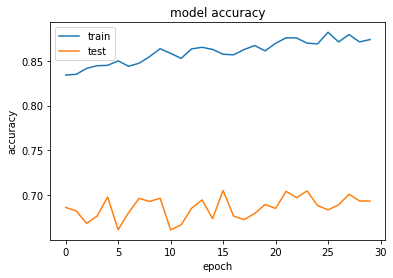

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss History

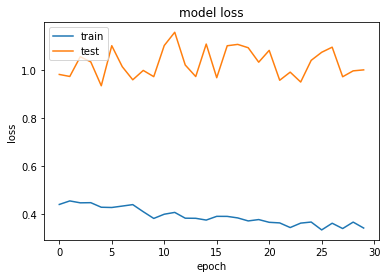

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
cnn.save('wts.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
